# **UNet Segmentation TEST (inference)**
### *Keras / Tensorflow 2*

*thomas.grenier@creatis.insa-lyon.fr*

Here, we load a pre-trained model based on UNet architecture that allows image segmentation.
UNet was initially proposed by Ronneberger in 2015 and is now the most used architecture for semantic image segmentation.

### <span style="color:brown"> **What is segmentation ?**

Segmentation is the process of assigning a label (that represents a class or an object) to a pixel.

If there is only one kind of object, segmentation is said to be a binary segmentation (ie object and backgrouond).
For more classes, segmentation is said multi-class segmenation.

The next figure illustrated available MRI images (WIP mDixon axial BW036 2nsa sshot HR2 TE2_3 FFE CLEAR, echo 2, 5 and 8) of shoulder from Geneva Hospital with the manual segmentation of 5 muscles done by experts (Jean-Baptiste Pialat, Lexane Rocle, Jeff Delorme):

<img src="figures/P02_71_e2_crop.png" alt="Segmentation" style="width: 22%;"/> <img src="figures/P02_71_e5_crop.png" alt="Segmentation" style="width: 22%;"/> <img src="figures/P02_71_e8_crop.png" alt="Segmentation" style="width: 22%;"/> <img src="figures/P02_71_crop.png" alt="Segmentation" style="width: 22%;"/>
    

In the following, we are going to segment in 2D these 5 muscles on such MRI (mainly using echo 8 images).

### <span style="color:brown"> **What is the difference between semantic segmentation and instance segmentation ?**

If several objects of the same class are present in an image, semantic segmentation assigns the same class to all these objects.
Instance segmentation will also dissociate each of these objects and allows a direct count of them.
One can note that the step of dissociation (or counting) can be done by classical image processing methods after a semantic segmentation.

<img src="figures/SemanticIntanceSegmentation.png" alt="Semantic vs Instance Segmentation" style="width: 75%;"/>    

**Here we focus on multi-class semantic segmentation** using U-Net deep neural network.

### <span style="color:brown"> **Unet in (very) brief**
This Network is fully **convolutional**. 
It uses skip connections from the encoder side to the decoder side to preserve scale information.

<img src="figures/UNet.png" alt="UNet" style="width: 70%;"/>

In this notebook, we start by using a trained network.


### <span style="color:red"> Question : </span> On the last convolution layer, how many filters are needed to segment our 5 muscles ?

## <span style="color:brown"> **1- System setting**

We start by loading necessary libraries and setting variables.
Some of them are related to data.
But, to ensure that the code works on almost all infrastructures, low-level system variable are also initialized. 

In [1]:
!pip install medpy
!pip install tqdm
!pip install keras_unet
!pip install numpy==1.23
#!pip install opencv-python

  Using cached MedPy-0.4.0-py3-none-any.whl
  Using cached scipy-1.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.5 MB)
  Using cached SimpleITK-2.3.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (52.7 MB)
  Using cached numpy-1.26.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.55.2 requires numpy<1.23,>=1.18, but you have numpy 1.26.3 which is incompatible.
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached keras_unet-0.1.2-py3-none-any.whl (16 kB)
  Using cached numpy-1.23.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing

In [2]:
import glob
import os
import sys
from datetime import datetime

from tqdm import tqdm 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

import cv2
import tensorflow as tf

if 'model' in locals(): 
    print("deleting model")
    del model    
    
# select the device (CPU or GPU) to run on
num_CPU = 1
num_cores = 4

# KERNEL msut be restarted if you change GPU 0 -> 1 or 1 -> 0 (cannot change runtime after initialization)
GPU = 1  # GPU = 0 => CPU Only ; GPU = 1 => use GPU

physical_gpu_devices = tf.config.list_physical_devices('GPU')
physical_cpu_devices = tf.config.list_physical_devices('CPU')
print(physical_gpu_devices)
print(physical_cpu_devices)

if GPU:
    tf.config.set_visible_devices(physical_gpu_devices[0], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    print(visible_devices)  
    for device in visible_devices:
        print(device)
    tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
    tf.config.threading.set_inter_op_parallelism_threads(num_cores) 
else:
    try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(device)
        assert device.device_type != 'GPU'
    except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass
    tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
    tf.config.threading.set_inter_op_parallelism_threads(num_cores)

2024-01-30 13:36:47.246043: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-30 13:36:53.225947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 13:36:53.235011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 13:36:53.238173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## <span style="color:brown"> **2- Load and Prepare images and model**

<span style="color:red">
    
> **Before running the cells of 2.1**, you have to download the **MODEL** ```dlss21_ho4_model```:
>    1.  link : https://www.creatis.insa-lyon.fr/~grenier/research/DLMI23/Unet_f32_b16_l5_do0.1_Std_BN_input96.h5
>    2.  copy in the directory than this notebook.
    
The next cell can do it for you:

In [3]:
# the following command works on linux and download the model
if not os.path.isfile("Unet_f32_b16_l5_do0.1_Std_BN_input96.h5"):
    !wget https://www.creatis.insa-lyon.fr/~grenier/research/DLMI23/Unet_f32_b16_l5_do0.1_Std_BN_input96.h5

--2024-01-30 13:36:53--  https://www.creatis.insa-lyon.fr/~grenier/research/DLMI23/Unet_f32_b16_l5_do0.1_Std_BN_input96.h5
Resolving www.creatis.insa-lyon.fr (www.creatis.insa-lyon.fr)... 195.220.108.5
Connecting to www.creatis.insa-lyon.fr (www.creatis.insa-lyon.fr)|195.220.108.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498227808 (475M) [application/mipc]
Saving to: ‘Unet_f32_b16_l5_do0.1_Std_BN_input96.h5’

Unet_f32_b16_l5_do0 100%[===================>] 475.15M  27.0MB/s    in 19s     

2024-01-30 13:37:13 (25.7 MB/s) - ‘Unet_f32_b16_l5_do0.1_Std_BN_input96.h5’ saved [498227808/498227808]



## <span style="color:brown"> 2.1- Load data

In [4]:
from keras_unet.utils import ReadImages, ReadMasks
from PIL import Image

In [5]:
## # test 
test_image_files     = glob.glob("./data/test/images/*.png")
test_masks_files = glob.glob("./data/test/labels/*.png")

# Data related values
IMG_WIDTH = 256
IMG_HEIGHT = 320

JUPYTER_DISPLAY_ON = True

model_filename = './pretrained_model/Unet_1i_dice95_epoch200.h5'

In [6]:
test_image_files.sort()
test_masks_files.sort()

print( " testing   :  ", 
      len(test_masks_files),
      len(test_image_files) )

# for segmentation 1
permutation_test = np.random.permutation( len(test_masks_files))
test_images_files_rnd = [test_image_files[i] for i in permutation_test]
test_masks_files_rnd     = [test_masks_files[i] for i in permutation_test]

 testing   :   365 365


In [7]:
# reading files
X_test = ReadImages(test_images_files_rnd, size=(IMG_WIDTH, IMG_HEIGHT))
Y_test = ReadMasks(test_masks_files_rnd, size=(IMG_WIDTH, IMG_HEIGHT))

# 1 MRI
input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

# 3 MRI
#input_shape = (IMG_SIZE, IMG_SIZE, 3)
#X_test = tf.keras.layers.Concatenate()([X_test_e8, X_test_e5, X_test_e2])

100%|██████████| 365/365 [00:00<00:00, 2768.90it/s]


In [8]:
print(" Shape X_test and y_test : ", X_test.shape,  Y_test.shape)
print(" Type test : ", X_test.dtype, Y_test.dtype)

print(" Max   : %lf , %lf"%(X_test.max(), Y_test.max()))
print(" Min   : %lf , %lf"%(X_test.min(), Y_test.min()))

 Shape X_test and y_test :  (365, 320, 256, 1) (365, 320, 256, 2)
 Type test :  float32 float32
 Max   : 0.996078 , 1.000000
 Min   : 0.000000 , 0.000000


### <span style="color:red"> Question : </span> Observe the min and max of data. Why range is so critical ?

## <span style="color:brown"> 2.2- Plot images + masks + overlay (mask over original)

Check, check and re-check again your data. 
Many mistakes come from data...

**The following cell displays images, manual annotations and an overlays for ease of visualization**
Nothing done by the network yet!

In [9]:
from keras_unet.visualization import plot_overlay_segmentation, plot_compare_segmentation

### Plot images with overlay (mask over original)

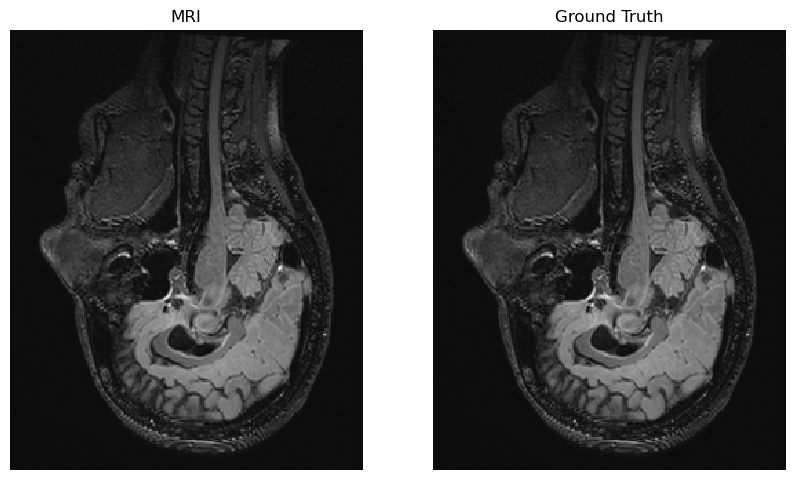

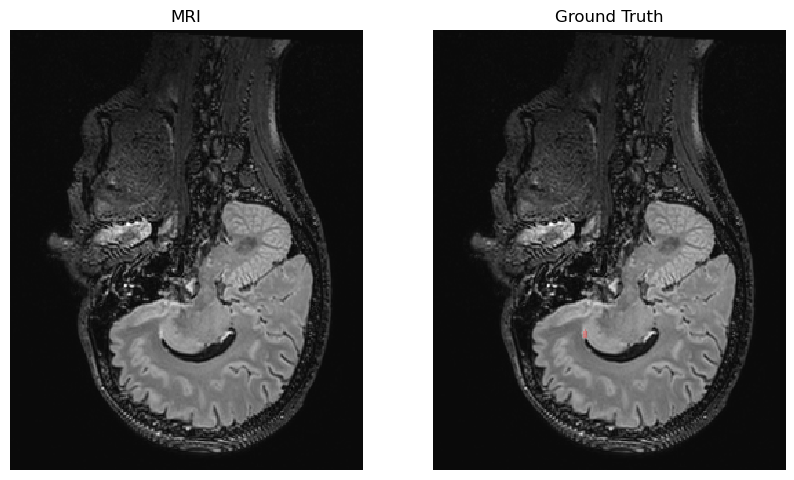

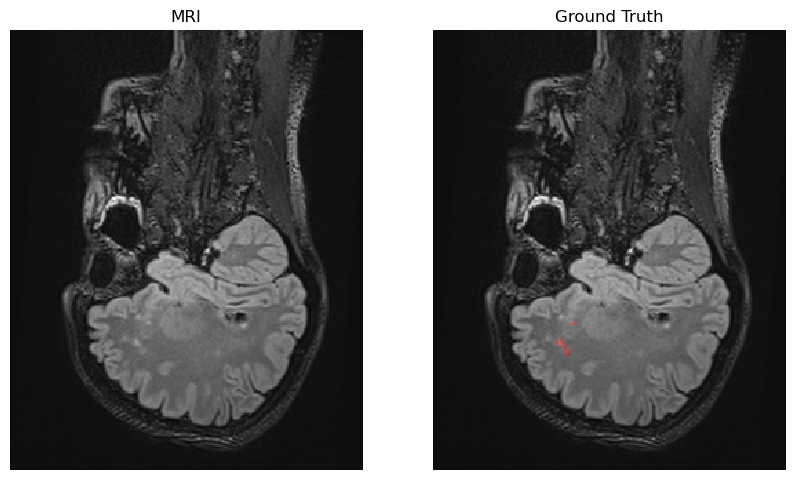

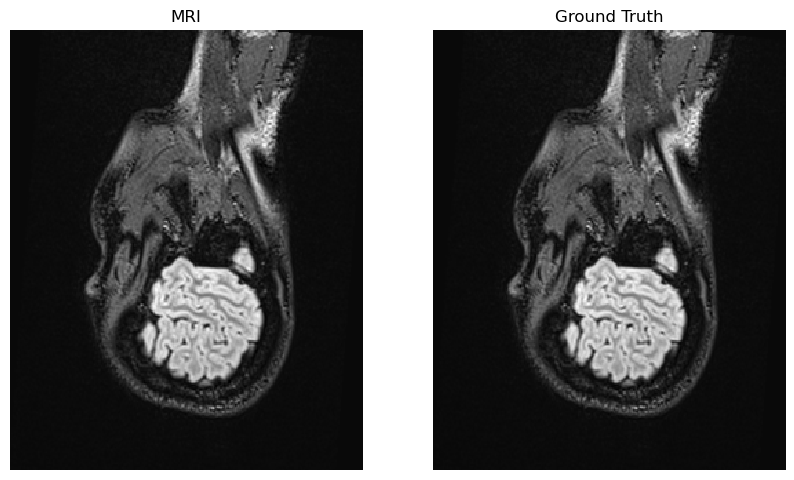

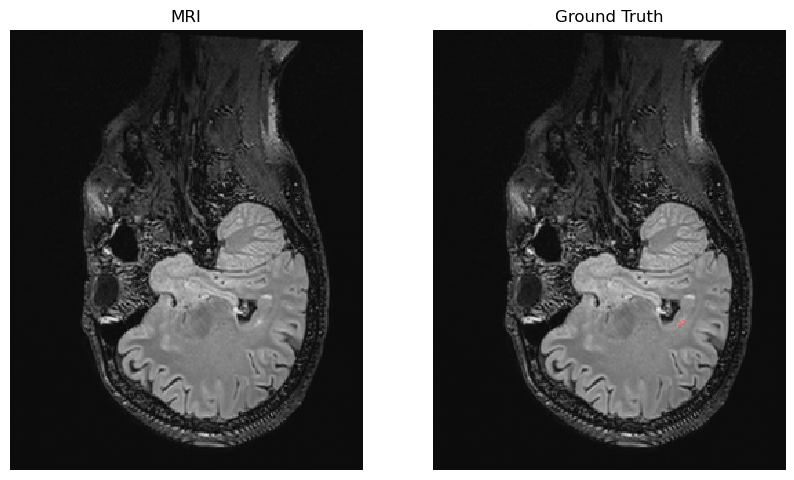

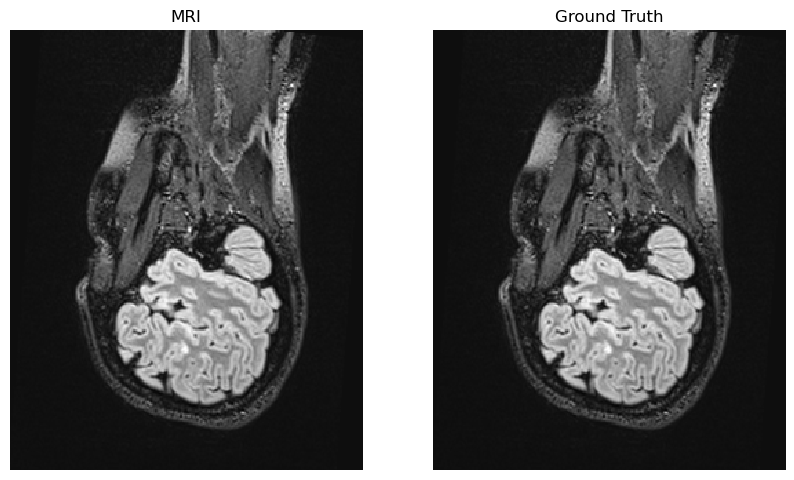

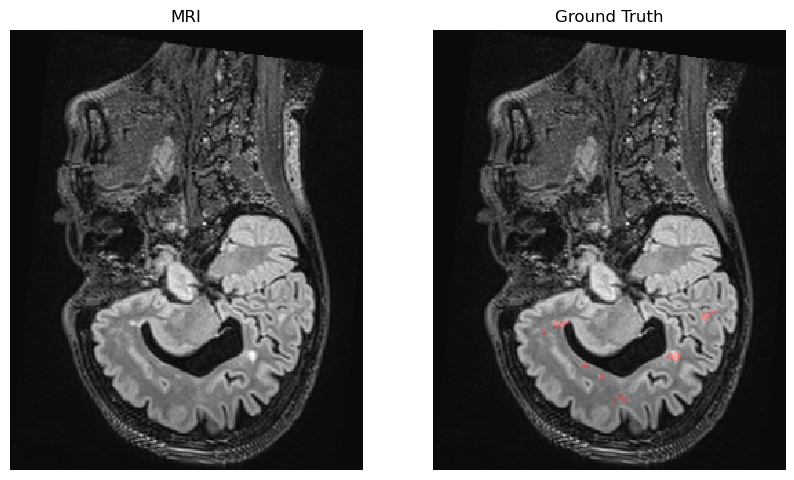

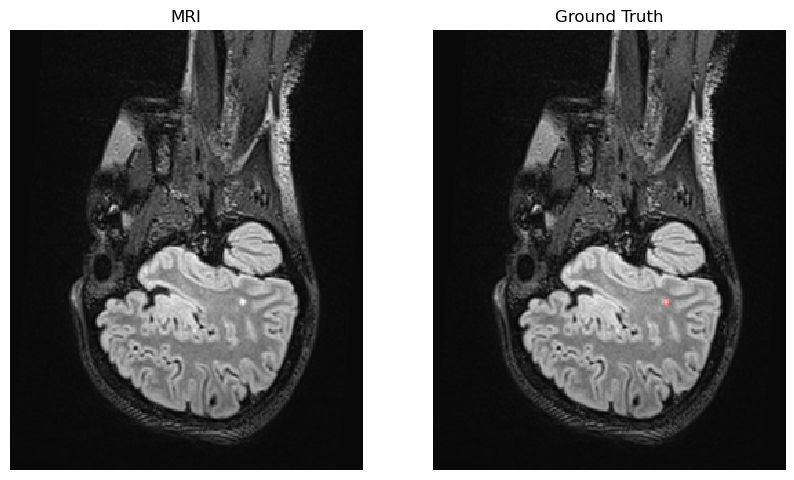

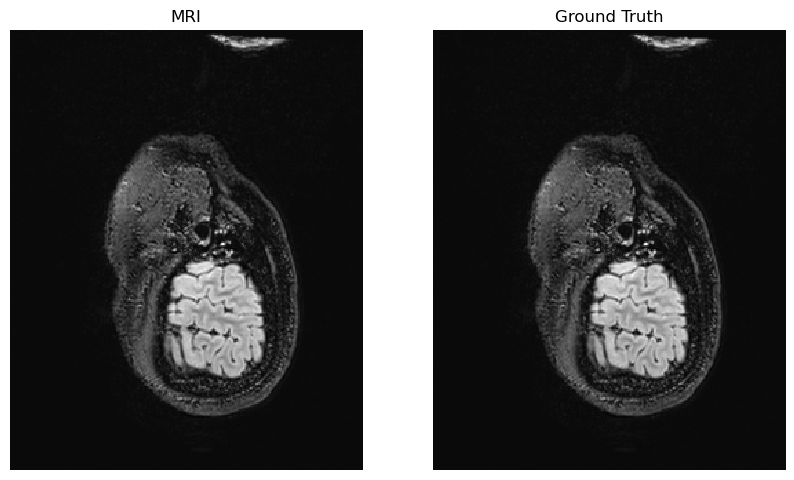

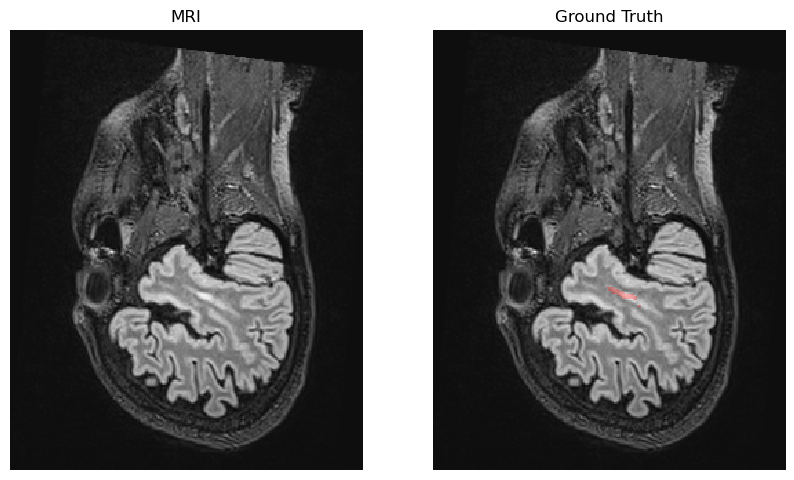

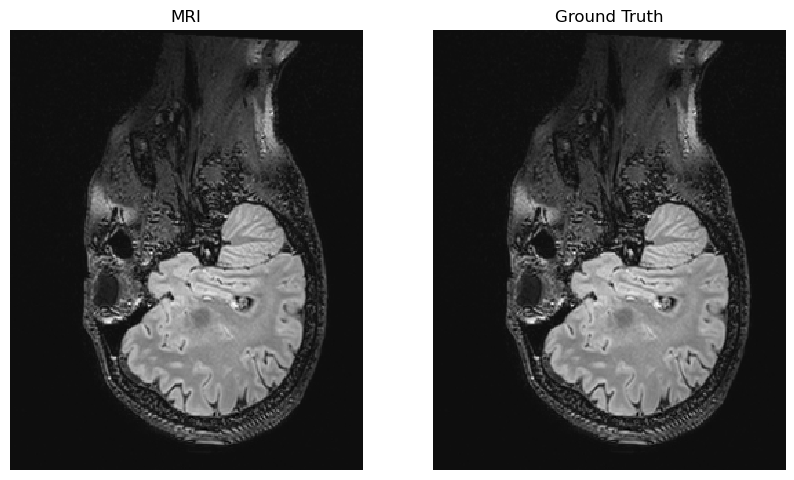

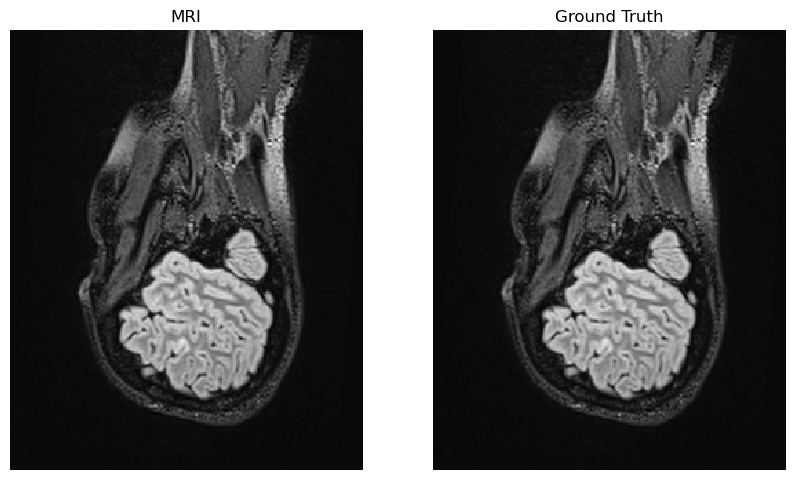

In [10]:
plot_overlay_segmentation(X_test[3:15], Y_test[3:15])

## <span style="color:brown"> **3- Load the network and its weights**

In [11]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import dice_loss, dice_coef, adaptive_loss
from tensorflow.keras import models

tf.keras.backend.clear_session()

# load the network with its custom functions
loaded_model = models.load_model(model_filename, custom_objects={'dice_coef': dice_coef, 'adaptive_loss': adaptive_loss, 'dice_loss': dice_loss})

loaded_model.summary()
'''
# Remove the existing output layer
loaded_model.layers.pop()

# Define a new output layer for binary classification
new_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='new_output')(loaded_model.layers[-1].output)

# Create a new model with the modified output layer
binary_classification_model = models.Model(inputs=loaded_model.input, outputs=new_output)

# Compile the new model
binary_classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the modified model
binary_classification_model.summary()
'''

2024-01-30 13:37:17.495528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 13:37:17.495849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 13:37:17.500193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 13:37:17.503222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 320, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_161 (Conv2D)            (None, 320, 256, 16  160         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_84 (Dropout)           (None, 320, 256, 16  0           ['conv2d_161[0][0]']             
                                )                                                           

"\n# Remove the existing output layer\nloaded_model.layers.pop()\n\n# Define a new output layer for binary classification\nnew_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='new_output')(loaded_model.layers[-1].output)\n\n# Create a new model with the modified output layer\nbinary_classification_model = models.Model(inputs=loaded_model.input, outputs=new_output)\n\n# Compile the new model\nbinary_classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Display the summary of the modified model\nbinary_classification_model.summary()\n"

## <span style="color:brown"> **4- Predict segmentations on the whole test set using the network**

In [12]:
y_pred = loaded_model.predict(X_test, batch_size=1, verbose=1)

2024-01-30 13:37:20.346295: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-01-30 13:37:21.033153: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-30 13:37:21.033979: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-30 13:37:21.034023: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-30 13:37:21.034927: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-30 13:37:21.035023: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


365/365 [==============================] - 5s 5ms/step


In [13]:
loss, dice_coef = loaded_model.evaluate(x=X_test, y=Y_test, batch_size=1, verbose=1) # 
print(f"loss : {loss}   dice_coeff : {dice_coef}")

365/365 [==============================] - 2s 6ms/step - loss: 0.0057 - dice_coef: 0.9179
loss : 0.005736334249377251   dice_coeff : 0.9179147481918335


## <span style="color:brown"> 4.1- Plot images : MRI with overlay of ground truth + MRI with prediction overlay

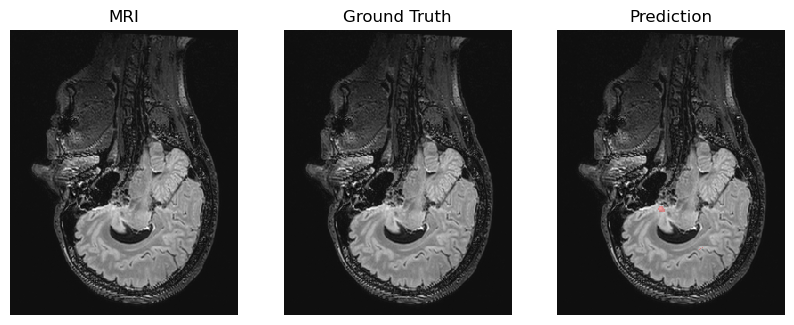

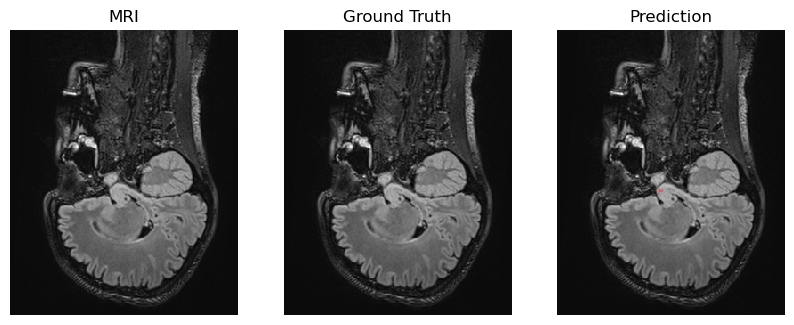

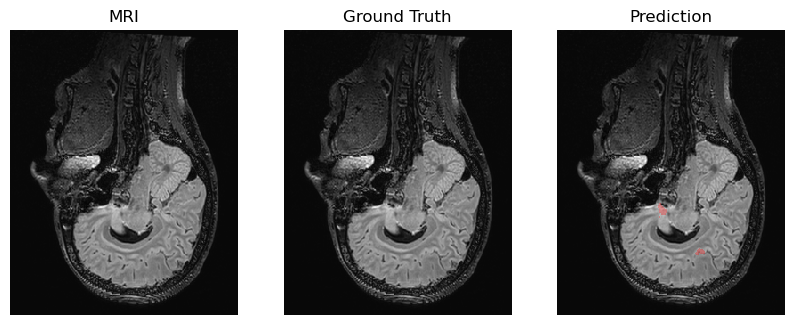

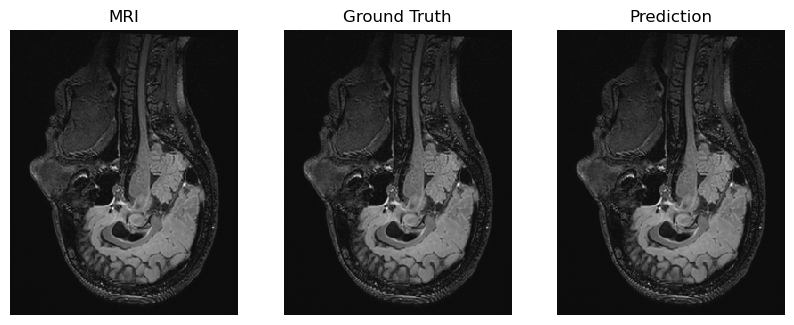

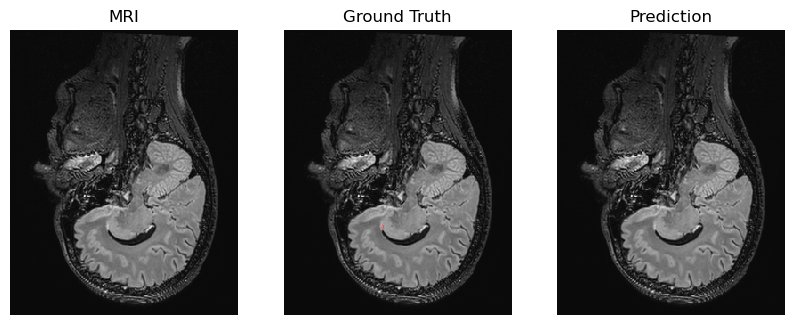

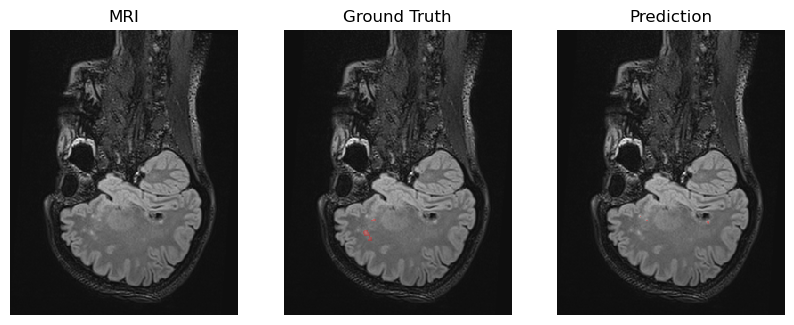

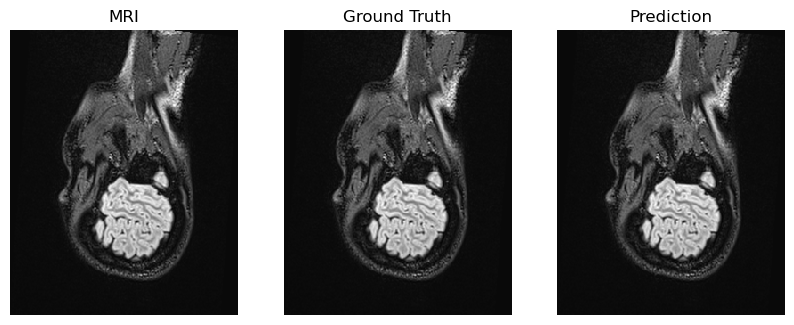

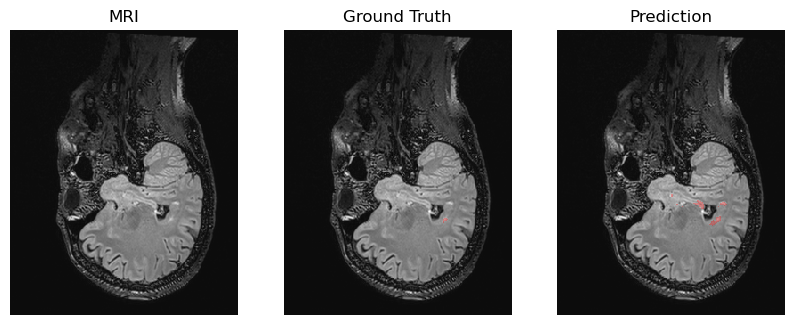

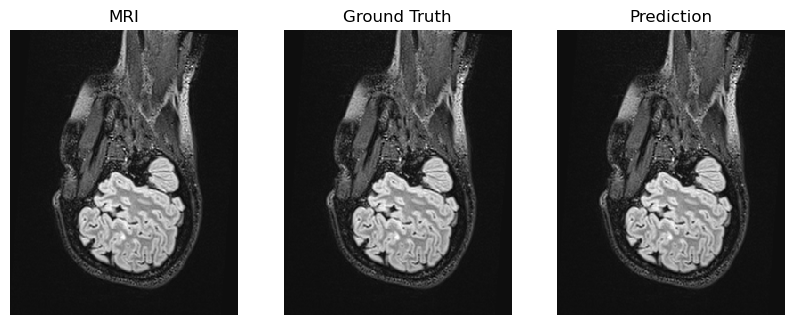

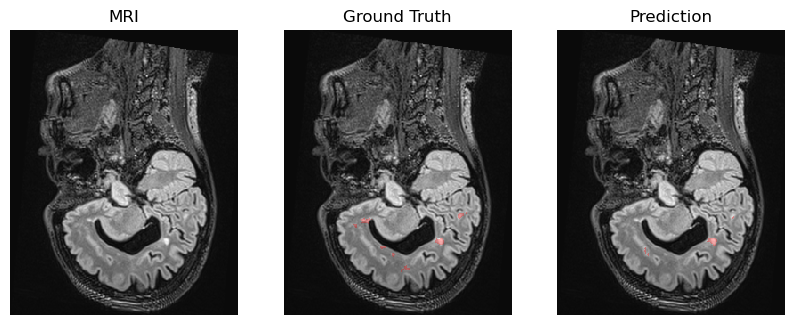

In [14]:
N_b = 0
N_e = 10
plot_compare_segmentation(X_test[N_b:N_e], Y_test[N_b:N_e], y_pred[N_b:N_e], " ", spacing=(1,1), step=1)

### <span style="color:red"> Question : </span>

- How the quality of this network is assessed ? what is Dice ?
- Visually consider images and the predictions, what is your qualitative assessment ?


### <span style="color:red"> Question : </span> Importance of 'device'.
- How long was the prediction time (or evaluation time)?
- This step ran on CPU. Now, change the GPU variable (1 -> 0) in the first cell of code and restart the kernel. Then run again the notebook. Compare the evaluate time. 

## <span style="color:brown"> 4.2- Evalaution with DICE/Hausdorff distance and Average symmetric surface distance
    
First, load the code.

In [15]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set

Then perform a unique evaluation

In [16]:
#from keras_unet import evaluation
dice, hausdorff, assds = evaluate_segmentation(Y_test[1], y_pred[1], voxel_spacing = [1, 1])
#dice = evaluate_segmentation(Y_test[1], y_pred[1], voxel_spacing = [1, 1])
print("Dice:", dice)
print("hausdorff:", hausdorff)
print("assds",assds)

Dice: [None, None]
hausdorff: [None, None]
assds [None, None]


Now, on the whole test set 

In [17]:
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set(Y_test, y_pred)

100%|██████████| 365/365 [00:03<00:00, 97.99it/s] 


In [18]:
print("dice_all", dice_all)
print("hausdorff", hausdorff_all)
print("assd", assd_all)

dice_all [0.27324426 0.27324426]
hausdorff [50.73598 50.73598]
assd [20.879253 20.879253]


Improve the rendering for your presentation ;)

[[ 0.27324426 50.73598    20.879253  ]
 [ 0.27324426 50.73598    20.879253  ]]


,Dice,Hausdorff,ASSD
All,0.273,50.736,20.879
1,0.273,50.736,20.879


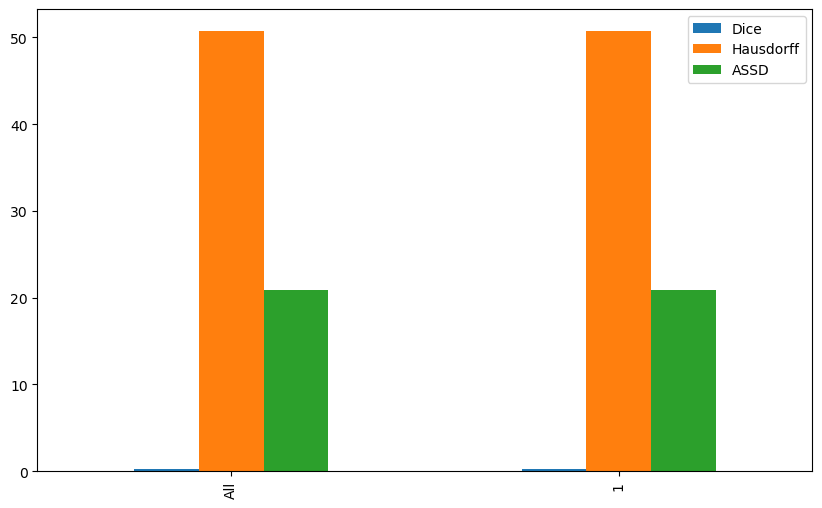

In [19]:
import pandas as pd
from IPython.display import display, HTML 

overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
print(overall_results)

# Graft our results matrix into pandas data frames 
overall_results_df = pd.DataFrame(data=overall_results, index = ["All", "1"], 
                                  columns=["Dice", "Hausdorff", "ASSD"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.3f' % x)))
overall_results_df.plot(kind='bar', figsize=(10,6)).legend() #bbox_to_anchor=(1.6,0.9))

Or to your paper (latex) :

In [20]:
#print(overall_results_df.to_latex(float_format=lambda x: '%.3f' % x)) # column_format='cccc'

# max Dice value in blod:
latex_tab = overall_results_df.style.highlight_max( props='textbf:--rwrap;', subset=["Dice"])
       
# min "Hausdorff", "ASSD" in bold
latex_tab.highlight_min( props='textbf:--rwrap;', subset=["Hausdorff", "ASSD"])

#limit decimal do different precision
latex_tab.format({
   "Dice": '{:.2f}',
   "Hausdorff": '{:.1f}',
   "ASSD": '{:.3f}'
})  

# generate latex code
print( latex_tab.to_latex(
    column_format="cccc", position="h", position_float="centering",
    hrules=True, label="table:SegmentationResults", caption="Averaged DSC, HD and ASSD on the test set",
    multirow_align="t", multicol_align="r")  )

\begin{table}[h]
\centering
\caption{Averaged DSC, HD and ASSD on the test set}
\label{table:SegmentationResults}
\begin{tabular}{cccc}
\toprule
 & Dice & Hausdorff & ASSD \\
\midrule
All & \textbf{0.27} & \textbf{50.7} & \textbf{20.879} \\
1 & \textbf{0.27} & \textbf{50.7} & \textbf{20.879} \\
\bottomrule
\end{tabular}
\end{table}



<span style="color:brown"> **Now :  1- Shutdown the Kernel**
    
    (menu --> Kernel --> " Shut down kernel..." )
    
    This will stop the kernel and free the ressources allocated (GPU memory...)
    
<span style="color:brown"> **Then : 2-  go to 2_UNET_TF2_train notebook to train your UNet!**